### Working with noisy data

Analytically, it's rather easy to show that the other notebooks work. However, having an imperfect data set will suggest if gained insights are applicable to real-world data.

White gaussian noise is printed on each component. Noise is uncorrelated. Afterwards, a lowpass filter is applied to get rid off any frequency above the main signal's frequency. It remains noise in the frequency range of the signal or lower.

Some notebooks are repeated here with the clue of using noisy data. The amplitude of the noise can be modulated by changing the variable SNR_dB_u and SNR_dB_r, translational and rotational components, respectively. It is the deci-bel strength of the noise in ratio to the signal (SNR = signal to noise ratio). If strain is included, SNR_dB_s modulates it's noise.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functions_anisotropy import *
from scipy.signal import butter,filtfilt
from scipy.linalg import null_space

In [2]:
medium = load_medium_list()

#0 isotropic
#1 taylor sandstone
#2 mesaverde clayshale
#3 mesaverde laminated siltstone
#4 mesaverde mudshale
#5 mesaverde calcareous sandstone
#6 quartz


In [3]:
index = 1
C, density = get_specific_VTI(medium[index])
#C, density = get_random_C('triclinic',30)

taylor sandstone
[[34.5974432   9.34087365 10.61386654  0.          0.          0.        ]
 [ 9.34087365 34.5974432  10.61386654  0.          0.          0.        ]
 [10.61386654 10.61386654 28.35856     0.          0.          0.        ]
 [ 0.          0.          0.          8.3631025   0.          0.        ]
 [ 0.          0.          0.          0.          8.3631025   0.        ]
 [ 0.          0.          0.          0.          0.         12.62828478]]


In [4]:
def awgn(x,SNR_dB):
    L = x.size
    SNR = 10**(SNR_dB/10)                  # SNR to linear scale
    Esym = np.sum(abs(x)**2,axis=None)/(L) # calculate actual symbol energy
    N0 = Esym / SNR                        # find the noise spectral density
    noiseSigma = np.sqrt(N0)               # standard deviation for AWGN Noise
    n = noiseSigma * np.random.randn(x[:,0].size,x[0,:].size) #computed noise
    return x + n                           # received signal

def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def lowpass(seis,f,fs,order=5):
    c, nt = np.shape(seis)
    seis_fil = np.zeros((c,nt))
    for i in range(0,c):
        seis_fil[i,:] = butter_lowpass_filter(seis[i,:], f, fs,order )
    return seis_fil

def make_some_noise(seis,SNR_dB_u,SNR_dB_r,SNR_dB_s=100.):
    c, nt = np.shape(seis)
    seis_noise = np.zeros((c,nt))
    seis_noise[0:3] = awgn(seis[0:3],SNR_dB_u)
    seis_noise[3:6] = awgn(seis[3:6],SNR_dB_r)
    if c>6:
        seis_noise[6:] = awgn(seis[6:],SNR_dB_s)
    return seis_noise

### Noisy data and low-pass filter

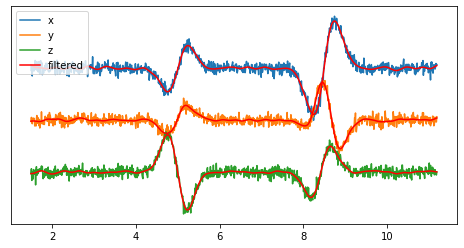

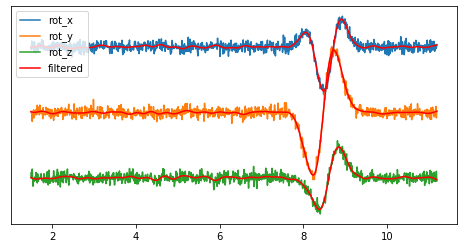

In [5]:
f = 3.
SNR_dB_u = 10
SNR_dB_r = 10
fs = 100.

nus, gammas = get_direction('random',C,1)
vel,v = get_eigenvals(gammas[0], density)
seis, t = get_seis(v, vel, nus[0], f, fs)
seis_noise = make_some_noise(seis,SNR_dB_u,SNR_dB_r)
seis_fil = lowpass(seis_noise,f,fs)

# plot results
a1 = abs(seis_noise[0:3][:].max())
plt.figure(figsize=(8,4))
plt.plot(t,seis_noise[0,:],label='x')
plt.plot(t,seis_noise[1,:]-a1,label='y')
plt.plot(t,seis_noise[2,:]-2*a1,label='z')
plt.plot(t,seis_fil[0,:],color='red',label='filtered')
plt.plot(t,seis_fil[1,:]-a1,color='red')
plt.plot(t,seis_fil[2,:]-2*a1,color='red')
plt.legend(loc=2)
plt.yticks([])
plt.show()

a2 = seis_noise[3:6][:].max()
plt.figure(figsize=(8,4))
plt.plot(t,seis_noise[3,:],label='rot_x')
plt.plot(t,seis_noise[4,:]-a2,label='rot_y')
plt.plot(t,seis_noise[5,:]-2*a2,label='rot_z')
plt.plot(t,seis_fil[3,:],color='red',label='filtered')
plt.plot(t,seis_fil[4,:]-a2,color='red')
plt.plot(t,seis_fil[5,:]-2*a2,color='red')
plt.legend(loc=2)
plt.yticks([])
plt.show()


### Direction of propagation

#1
Estimated direction of propagation:
Theta: 48.61267958387801
Phi: 77.56648367761856
Actual direction of propagation:
Theta: 44.415477819391704
Phi: 78.12
Error (order of magnitude):
-1.1332850687287646


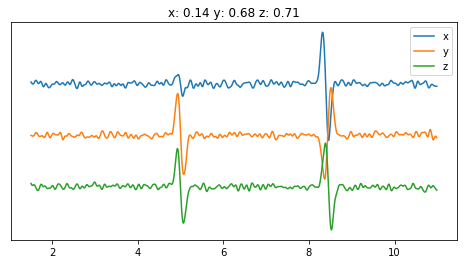

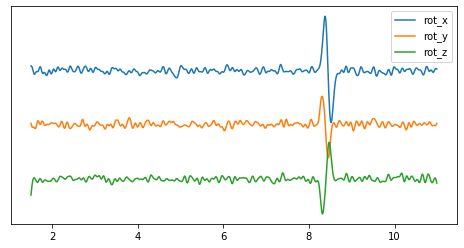

---------------------------------- 
#2
Estimated direction of propagation:
Theta: 57.37591535385962
Phi: -87.45446464538928
Actual direction of propagation:
Theta: 60.36089325788251
Phi: -91.8
Error (order of magnitude):
-1.0798724590988003
---------------------------------- 
#3
Estimated direction of propagation:
Theta: 60.39803311355205
Phi: -79.80718248528868
Actual direction of propagation:
Theta: 56.218408399086655
Phi: -85.32
Error (order of magnitude):
-0.9603326342077186
---------------------------------- 
#4
Estimated direction of propagation:
Theta: 35.29760161965067
Phi: 77.98419403876902
Actual direction of propagation:
Theta: 39.012485811308046
Phi: 81.72
Error (order of magnitude):
-1.1202356137778708
---------------------------------- 
#5
Estimated direction of propagation:
Theta: 68.4233407533728
Phi: -179.46146835917136
Actual direction of propagation:
Theta: 42.616390342680916
Phi: 157.32000000000002
Error (order of magnitude):
-0.260385206636385
---------------------

In [6]:
f = 10.
fs = 100.
SNR_dB_u = 5.
SNR_dB_r = 0.
N = 5

r2d = 180/np.pi
### generating some traces
for i in range(0,N):
    nus, gammas = get_direction('random',C,1)
    vel,v = get_eigenvals(gammas[0], density)
    seis, t = get_seis(v, vel, nus[0], f, fs)
    seis = make_some_noise(seis,SNR_dB_u,SNR_dB_r)
    seis = lowpass(seis,f,fs)
    theta, phi = get_angles(nus[0])
    nu_e = get_propagation_direction(seis)
    theta_e, phi_e = get_angles(nu_e)
    print('#'+str(i+1))
    print('Estimated direction of propagation:')
    print('Theta: '+str(theta_e*r2d))
    print('Phi: '+str(phi_e*r2d))
    print('Actual direction of propagation:')
    print('Theta: '+str(theta*r2d))
    print('Phi: '+str(phi*r2d))
    print('Error (order of magnitude):')
    err = np.sqrt((nus[0][0]-nu_e[0])**2+(nus[0][1]-nu_e[1])**2+(nus[0][2]-nu_e[2])**2)
    print(np.log10(err))
    if i%5==0:
        plotseis(seis,t,nus[0])
    print('---------------------------------- ')


### Propagation direction of single wavefront

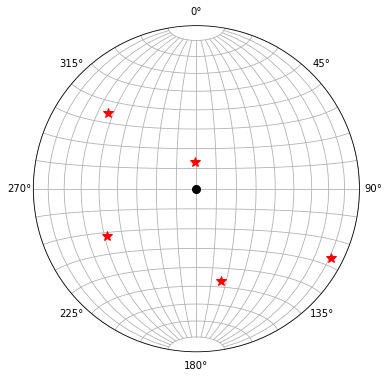

#1


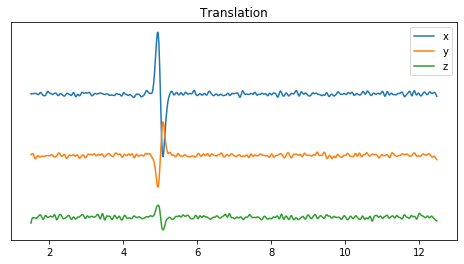

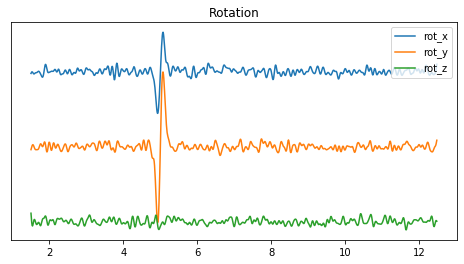

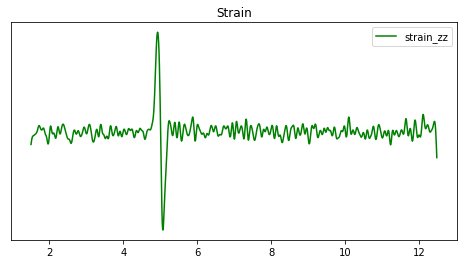

Estimated direction of propagation:
Theta: 82.04077559656363
Phi: -27.546060595047557
Actual direction of propagation:
Theta: 81.98432044611978
Phi: -27.35999999999999
Error (order of magnitude):
-2.4732177801304607
---------------------------------- 
#2
Estimated direction of propagation:
Theta: 51.37398831996185
Phi: -153.2778725214332
Actual direction of propagation:
Theta: 51.892577045848945
Phi: -152.28000000000003
Error (order of magnitude):
-1.7856286262637822
---------------------------------- 
#3
Estimated direction of propagation:
Theta: 60.62852055557695
Phi: 139.84218627683128
Actual direction of propagation:
Theta: 60.90520316325679
Phi: 139.32000000000002
Error (order of magnitude):
-2.031314554856188
---------------------------------- 
#4
Estimated direction of propagation:
Theta: 59.17267071688337
Phi: -21.40547549995246
Actual direction of propagation:
Theta: 13.515863927986407
Phi: 93.96000000000001
Error (order of magnitude):
0.03509850634794127
---------------------

In [18]:
f = 10.
fs = 100.
N = 5
SNR_dB_u = 5.
SNR_dB_r = 0.
SNR_dB_s = 0.
wavetype = 'qP' #'qP','qS1','qS2'

nus, gammas = get_direction('random',C,N)
plot_directions(nus)
r2d = 180/np.pi
for i in range(0,len(nus)):
    vel, v = get_eigenvals(gammas[i], density)
    seis, t = get_seis_one_wavetype(wavetype,v,vel,nus[i],f,fs)
    seis = make_some_noise(seis,SNR_dB_u,SNR_dB_r,SNR_dB_s=SNR_dB_s)
    seis = lowpass(seis,f,fs)
    
    n,_,_ = get_polarizations(seis,'trans')
    
    it = np.argmax(seis[6,:])
    rx = seis[3,it]
    ry = seis[4,it]
    ezz = seis[6,it]
    
    nu_e = np.zeros(3) 
    nu_e[2] = 1.
    nu_e[1] = 2*rx/ezz + n[1]/n[2]
    nu_e[0] = -2*ry/ezz + n[0]/n[2]

    l = 0
    for j in range(0,3):
        l += nu_e[j]**2
    nu_e = nu_e / np.sqrt(l)
    
    print('#'+str(i+1))
    if i==0:
        plot_7C(seis,t)
    theta_e, phi_e = get_angles(nu_e)
    theta, phi = get_angles(nus[i])
    print('Estimated direction of propagation:')
    print('Theta: '+str(theta_e*r2d))
    print('Phi: '+str(phi_e*r2d))
    print('Actual direction of propagation:')
    print('Theta: '+str(theta*r2d))
    print('Phi: '+str(phi*r2d))
    print('Error (order of magnitude):')
    err = np.sqrt((nus[i][0]-nu_e[0])**2+(nus[i][1]-nu_e[1])**2+(nus[i][2]-nu_e[2])**2)
    print(np.log10(err))
    print('---------------------------------- ')

### Polarizations

In [19]:
f = 10.
fs = 100.
f = 3.
SNR_dB_u = 5.
SNR_dB_r = 0.

N = 5
for i in range(0,N):
    nus, gammas = get_direction('random',C,1)
    vel,v = get_eigenvals(gammas[0], density)
    seis, t = get_seis(v, vel, nus[0], f, fs)
    seis = make_some_noise(seis,SNR_dB_u,SNR_dB_r)
    seis = lowpass(seis,f,fs)
    n = get_polarizations(seis,'trans')
    print('#'+str(i+1))
    print('Estimated Polarizations','              -  ','True Polarizations')
    print(n[0],'  -  ',v[:,0])
    print(n[1],'  -  ',v[:,1])
    print(n[2],'  -  ',v[:,2])
    print(' ')
   

#1
Estimated Polarizations               -   True Polarizations
[-0.11055617 -0.89168196 -0.43895401]   -   [0.08658167 0.85834046 0.50572253]
[ 0.99258925 -0.1168005  -0.01273018]   -   [ 9.94951017e-01 -1.00361715e-01 -2.30006727e-16]
[-0.04334809 -0.46476734  0.88437111]   -   [-0.05075518 -0.50316914  0.8626962 ]
 
#2
Estimated Polarizations               -   True Polarizations
[-0.62328874 -0.36165439  0.69333776]   -   [-0.64189428 -0.28740213  0.71089503]
[-0.4489895   0.89118401  0.06122632]   -   [-0.64882792 -0.2905066  -0.70329812]
[-0.65326833 -0.28081856 -0.70312262]   -   [-4.08649075e-01  9.12691587e-01 -7.46933696e-17]
 
#3
Estimated Polarizations               -   True Polarizations
[-0.64659285  0.37964474  0.66165516]   -   [-0.62505982  0.45413254  0.6348731 ]
[-0.54104183 -0.83563849 -0.04925228]   -   [ 5.87785252e-01  8.09016994e-01 -1.66646421e-16]
[ 0.48185098 -0.35908913  0.79929634]   -   [ 0.51362313 -0.37316905  0.77261643]
 
#4
Estimated Polarizations     

In [9]:
#C, density = get_random_C('orthorhombic',30)
C, density = get_specific_VTI(medium[3])

mesaverde laminated siltstone
[[60.1278135  22.62128644 38.25576711  0.          0.          0.        ]
 [22.62128644 60.1278135  38.25576711  0.          0.          0.        ]
 [38.25576711 38.25576711 50.86955457  0.          0.          0.        ]
 [ 0.          0.          0.         17.17331825  0.          0.        ]
 [ 0.          0.          0.          0.         17.17331825  0.        ]
 [ 0.          0.          0.          0.          0.         18.75326353]]


### Inversion

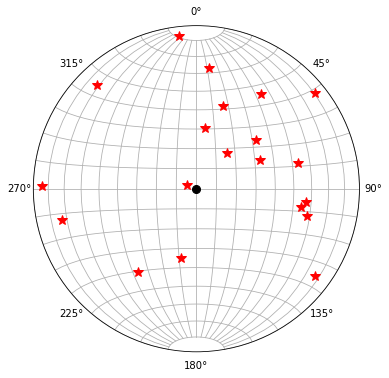

#1
True velocities
5015.303362025079 [2663.3415845409154, 1931.8173644489511]
Estimated velocities
[3333.440771289169, 2623.161381492382, 1923.9338429895874]
 
#2
True velocities
4912.667349007565 [2624.4386096168582, 1882.9369423552703]
Estimated velocities
[7592.685502531779, 2637.293805889207, 1880.958320397215]
 
#3
True velocities
4856.403120926923 [2616.3362833557194, 1961.192647024016]
Estimated velocities
[5539.819541725055, 2739.1413932049973, 2002.5779336067533]
 
#4
True velocities
4985.331739417429 [2678.139896522655, 2120.105123094074]
Estimated velocities
[3104.1487762067086, 2660.7123911937842, 2103.6563924926672]
 
#5
True velocities
4468.767138170602 [2585.9539432984466, 2556.3356129982194]
Estimated velocities
[3967.6678684762664, 2580.1236378872327, 2529.459551405822]
 
#6
True velocities
4992.27273287649 [2642.4258041869152, 1819.9190612618913]
Estimated velocities
[4283.449952119532, 2609.352989911101, 1837.060449592342]
 
#7
True velocities
4856.519394095288 [2699

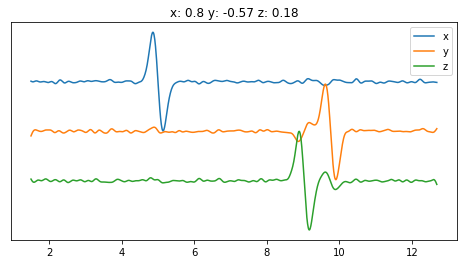

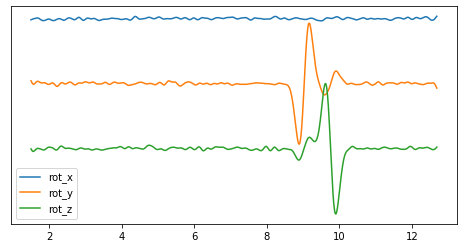

#13
True velocities
4871.454554148656 [2697.612257952381, 2496.1391668259675]
Estimated velocities
[7497.572925348571, 2700.8730023695634, 2411.3019640020652]
 
#15
True velocities
5003.711695960678 [2671.5921704712946, 2026.3230138085798]
Estimated velocities
[3184.9966964809605, 2680.392711311607, 2081.272688426637]
 
#16
True velocities
4850.796386865367 [2699.8823696684985, 2550.167642278492]
Estimated velocities
[5082.769820188748, 2686.598186343453, 2608.1323291437757]
 
#17
True velocities
5010.209848367177 [2668.046299818662, 1982.4137606738354]
Estimated velocities
[3713.6411798810977, 2576.12259079097, 1982.8128603613395]
 
#19
True velocities
4916.871799218425 [2625.1361653470094, 1877.6532624434535]
Estimated velocities
[5210.67064046993, 2634.590738088183, 1918.6183143699395]
 
Estimated Elastic tensor:
[[83.45477663 51.20275101 49.12471958]
 [51.20275101 59.91310865 39.37152805]
 [49.12471958 39.37152805 52.97422801]]
[[ -3.40328044 -11.28740309  -3.73216761]
 [ -7.975146

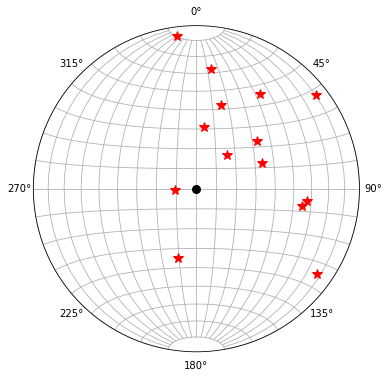

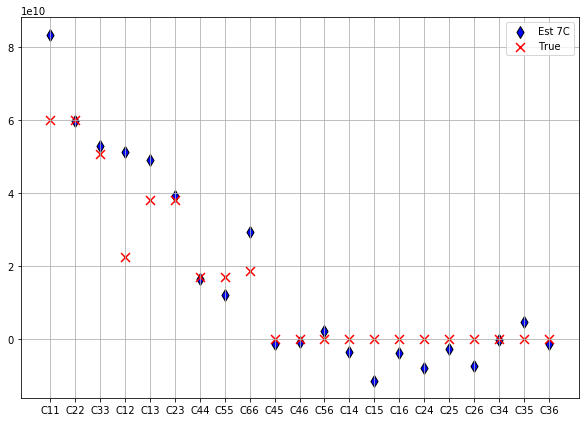

In [10]:
f = 5.
fs = 100.
SNR_dB_u = 10
SNR_dB_r = 10
N = 20
mode = 'triclinic'

d = np.array([])
G = np.array([])
C_e = np.zeros((6,6))
misfits = []
nu_used = []
nus, gammas = get_direction('random',C,N+2,theta_e=0.,phi_e=0.)
plot_directions(nus[1:N+1])

all_nu_e = []
all_seis = []
all_t = []
for i in range(1,N+1):
    vel, v = get_eigenvals(gammas[i], density)
    seis, t = get_seis(v,vel,nus[i],f,fs) 
    seis = make_some_noise(seis,SNR_dB_u,SNR_dB_r)
    seis = lowpass(seis,f,fs)
        
    all_seis.append(seis)
    all_t.append(t)
    
    n_trans = get_polarizations(seis,'trans')
    nu_e = get_propagation_direction(seis)
    all_nu_e.append(nu_e)
    vel_e,seis_rot,_ = estimate_velocity(seis,nu_e,t)
    if vel_e[0]==0. or vel_e[0]<vel_e[1] or vel_e[0]/3 >vel_e[1]:
        pass
    else:
        nu_used.append(nu_e)
        if len(nu_used)%10 == 0:
            plotseis(seis_rot,t,nu_e)
        d,G = add_new_data(mode,d,G,nu_e,vel_e,n_trans,density)
            
        print('#'+str(i))
        #print('Nullspace dimension: '+str(np.shape(null_space(G))[1]))
        print('True velocities')
        print(max(vel),extract_slower_velocities(vel))
        print('Estimated velocities')
        print(vel_e)
        print(' ')  

Q = np.linalg.inv(np.dot(G.transpose(),G))         
m = np.dot(np.dot(Q,G.transpose()),d)
C_e = sort_elastic_coeff(mode,m)  
eps = np.dot(G,m)
     
print('Estimated Elastic tensor:')
print(C_e[:3,:3]*1e-9)
print(C_e[:3,3:]*1e-9)
print(C_e[3:,3:]*1e-9)
print(' ')
print('Accurate Elastic tensor:')
print(C[:3,:3]*1e-9)
print(C[:3,3:]*1e-9)
print(C[3:,3:]*1e-9)
print(' ')

print(' ')
print('Average misfit:')
print(np.sqrt(np.dot(d-eps,d-eps))/len(nu_used))
print(' ')

print('Used Events: '+str(len(nu_used)))
print('Rate: '+str(round(len(nu_used)/N*100,2))+'%')
print(' ') 

plot_directions(nu_used)

plot_tensor_estimation(C,C_e)